In [ ]:
from helper import *
import numpy as np
import pandas as pd
import scipy.sparse as sparse
from scipy.stats.stats import pearsonr
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc

<ipython-input-2-777df0ca4d50>:5: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


# Clustering airports

In [ ]:
# Read Airports network
airports = nx.read_graphml("flights_network.graphml")
G = airports

number of edges 19080
number of nodes 3330
min degree 1
max degree 248
Is connected ? False
number of connected components:  7


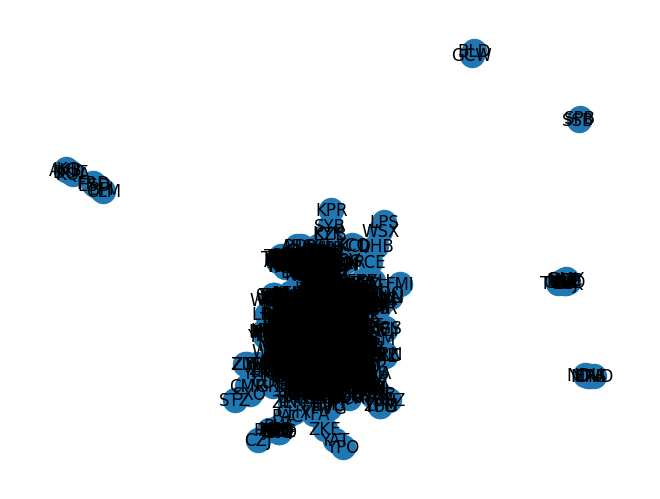

In [ ]:
def GetInfoGraph(G):
    print('number of edges', G.number_of_edges())
    print('number of nodes', G.number_of_nodes())
    print('min degree', np.min([degree[1] for degree in G.degree()])) # minimum degree
    print('max degree', np.max([degree[1] for degree in G.degree()]))# maximum degree
    #print('VERTICES', G.nodes())
    #print('EDGES', G.edges())
    print('Is connected ?', nx.is_connected(G))
    print('number of connected components: ', nx.number_connected_components(G))
    nx.draw(G, with_labels =True)

GetInfoGraph(G)

In [ ]:
def spectral_clustering(G, k):
    '''
    :param G: given graph
    :param k: the number of clusters
    :return partition: a list of node sets where each node set indicates a cluster
    '''
    
    # For a given undirected connected graph
    
    nodelist = list(G)  # keep the node orders
    A = np.array(nx.adjacency_matrix(G, nodelist).todense())
    D = np.diag(np.sum(A, axis=1))
    L = D - A # Laplacian matrix
    
    eigvals, eigvects = np.linalg.eig(L)
    eigvals = eigvals.real
    eigvects = eigvects.real
    # Sort the eigenvectors corresponding to their eigenvalues
    idx = np.argsort(eigvals)
    # eigvals = eigvals[idx]
    eigvects = eigvects[:,idx]
    
    # Retrieve top k eigenvectors wrt eigenvalue
    X = eigvects[:, 0:k]
    
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    
    partition = [set() for _ in range(k)]
    for i in range(len(nodelist)):
        partition[kmeans.labels_[i]].add(nodelist[i])
            
    return partition

It was observed that the dataset consists of 7 connected components, in order to facilitate the analysis we will now work exclusively on the largest component which contains 99.2% of the airports of the world air traffic.

In [ ]:
largest_cc = max(nx.connected_components(G), key=len)
G0 = G.subgraph(largest_cc)

number of edges 19055
number of nodes 3304
min degree 1
max degree 248
Is connected ? True
number of connected components:  1


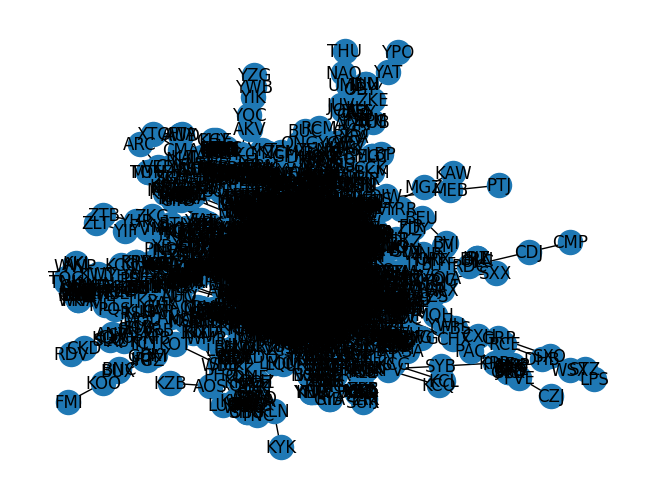

In [ ]:
GetInfoGraph(G0)

We perform a clustering task with the Spectral Clustering method, the idea is to look for 5 clusters in order to try to find the 5 contents.

In [ ]:
spectral_partition = spectral_clustering(G0, k=5)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
def visualize_graph(G, partition1):
    colors=['r', 'b', 'g', 'm', 'y', 'k']
    if len(partition1) > len(colors):
        raise ValueError("There is no enough colors, you can add more colors to the list!")
    
    
    pos=nx.spring_layout(G) # positions for all nodes
    
    #plt.subplot(1,1)
    plt.figure(figsize=(12,12))
    for commId, nodeset in enumerate(partition1):
        nx.draw_networkx_nodes(G, pos, nodelist=nodeset, node_color=colors[commId], node_size=100, alpha=0.4)
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    
    plt.show()

In [ ]:
def weighted_closeness_centrality(graph):
    '''
    :param graph:
    :return:
        closeness_centrality:
        Dictionary of nodes with closeness centrality as the value
    '''
    closeness_centrality = {}
    ### Please write your code below
    for node in graph.nodes():
        closeness_centrality[node] = nx.closeness_centrality(graph, node, distance='total_flights')
        
    sorted_nodes = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)
    for node, centrality in sorted_nodes:
        print(f"Node {node}: closeness centrality = {centrality}")
    ###
    return closeness_centrality

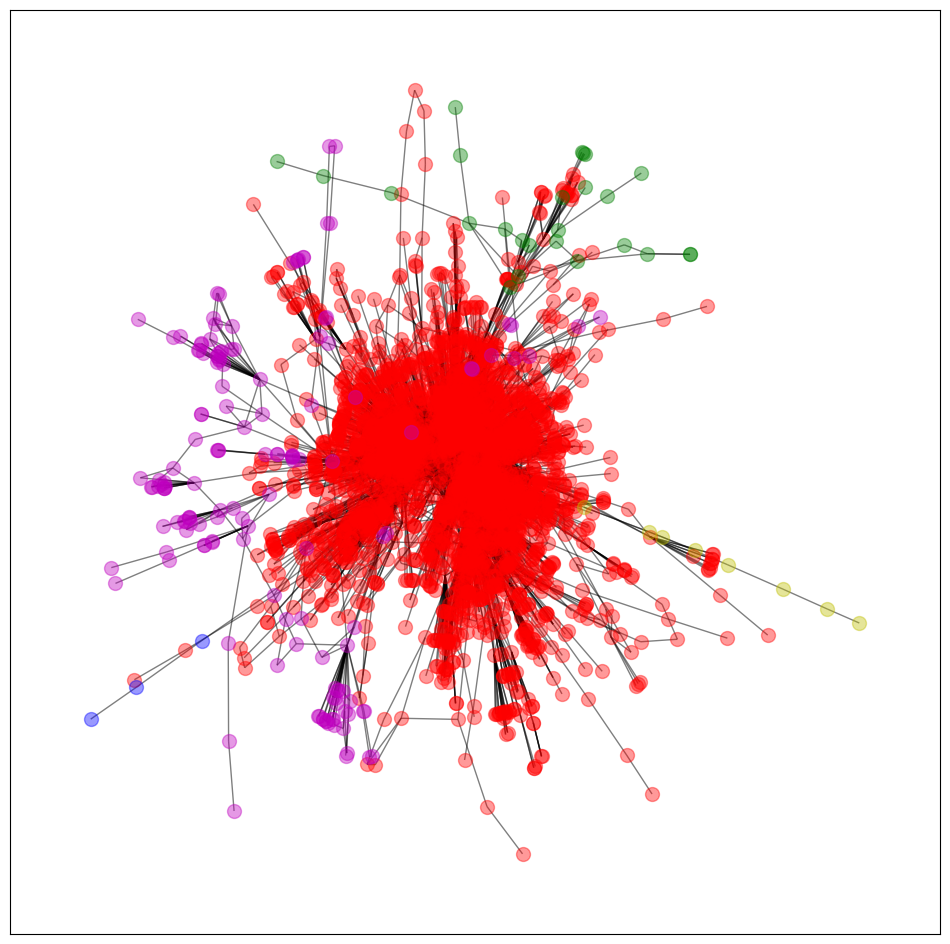

In [ ]:
visualize_graph(G0, spectral_partition)

In order to identify the important airports of each cluster, we calculate for each node its Weighted Closeness Centrality within the cluster to which it belongs. The results are stored in the closeness_clusters variable.

In [ ]:
closeness_clusters = []
for s in spectral_partition:
  cluster = G0.subgraph(s)
  closeness_clusters.append(weighted_closeness_centrality(cluster))

Node FRA: closeness centrality = 0.4216508795669824
Node CDG: closeness centrality = 0.4184235262521821
Node LHR: closeness centrality = 0.4159658256574556
Node AMS: closeness centrality = 0.4115161119915478
Node DXB: closeness centrality = 0.4107025174640833
Node JFK: closeness centrality = 0.40378385382920823
Node LAX: closeness centrality = 0.39984601565507505
Node YYZ: closeness centrality = 0.3987204094689699
Node IST: closeness centrality = 0.3981091094927814
Node MUC: closeness centrality = 0.3961856325492689
Node PEK: closeness centrality = 0.394980352389403
Node FCO: closeness centrality = 0.39378238341968913
Node NRT: closeness centrality = 0.3916540975364505
Node DOH: closeness centrality = 0.3912115505335844
Node ICN: closeness centrality = 0.39101518383736983
Node EWR: closeness centrality = 0.39077000250815147
Node ORD: closeness centrality = 0.3899874843554443
Node ZRH: closeness centrality = 0.38881956575992016
Node HKG: closeness centrality = 0.3882866043613707
Node MA

In [ ]:
for i,closeness_cluster in enumerate(closeness_clusters):
  print("Number of airports in cluster",i+1,":",len(closeness_cluster))
  sorted_cluster = sorted(closeness_cluster.items(), key=lambda x:x[1], reverse=True)
  converted_dict = dict(sorted_cluster)
  top3 = list(converted_dict.items())[:3]
  print("Top 3 closeness centrality airports in cluster",i+1,top3)

Number of airports in cluster 1 : 3117
Top 3 closeness centrality airports in cluster 1 [('FRA', 0.4216508795669824), ('CDG', 0.4184235262521821), ('LHR', 0.4159658256574556)]
Number of airports in cluster 2 : 3
Top 3 closeness centrality airports in cluster 2 [('SXO', 1.0), ('STZ', 0.6666666666666666), ('GRP', 0.6666666666666666)]
Number of airports in cluster 3 : 25
Top 3 closeness centrality airports in cluster 3 [('GOH', 0.5106382978723404), ('SFJ', 0.47058823529411764), ('JAV', 0.42105263157894735)]
Number of airports in cluster 4 : 151
Top 3 closeness centrality airports in cluster 4 [('ANC', 0.4983388704318937), ('BET', 0.39267015706806285), ('FAI', 0.3816793893129771)]
Number of airports in cluster 5 : 8
Top 3 closeness centrality airports in cluster 5 [('FBS', 0.4375), ('RCE', 0.4375), ('LKE', 0.3888888888888889)]


# Supervised Link Prediction

In [ ]:
def generate_samples(graph, train_set_ratio):
    """
    Graph pre-processing step required to perform supervised link prediction
    Create training and test sets
    Citation: Lab 2
    """
        
    # --- Step 0: The graph must be connected ---
    if nx.is_connected(graph) is not True:
        raise ValueError("The graph contains more than one connected component!")
       
    # --- Step 1: Generate positive edge samples for testing set ---
    residual_g = graph.copy()
    test_pos_samples = []
      
    # Store the shuffled list of current edges of the graph
    edges = list(residual_g.edges())
    np.random.shuffle(edges)
    
    # Define number of positive test samples desired
    test_set_size = int((1.0 - train_set_ratio) * graph.number_of_edges())
    train_set_size = graph.number_of_edges() - test_set_size
    num_of_pos_test_samples = 0
    
    # Remove random edges from the graph, leaving it connected
    # Fill in the blanks
    for edge in edges:
        
        # Remove the edge
        residual_g.remove_edge(edge[0], edge[1])
        
        # Add the removed edge to the positive sample list if the network is still connected
        if nx.is_connected(residual_g):
            num_of_pos_test_samples += 1
            test_pos_samples.append(edge)
        # Otherwise, re-add the edge to the network
        else: 
            residual_g.add_edge(edge[0], edge[1])
        
        # If we have collected enough number of edges for testing set, we can terminate the loop
        if num_of_pos_test_samples == test_set_size:
            break
    
    # Check if we have the desired number of positive samples for testing set 
    if num_of_pos_test_samples != test_set_size:
        raise ValueError("Enough positive edge samples could not be found!")

        
    # --- Step 2: Generate positive edge samples for training set ---
    # The remaining edges are simply considered for positive samples of the training set
    train_pos_samples = list(residual_g.edges())
        
        
    # --- Step 3: Generate the negative samples for testing and training sets ---
    # Fill in the blanks
    non_edges = list(nx.non_edges(graph))
    np.random.shuffle(non_edges)
    
    train_neg_samples = non_edges[:train_set_size] 
    test_neg_samples = non_edges[train_set_size:train_set_size + test_set_size]

    
    # --- Step 4: Combine sample lists and create corresponding labels ---
    # For training set
    train_samples = train_pos_samples + train_neg_samples
    train_labels = [1 for _ in train_pos_samples] + [0 for _ in train_neg_samples]
    # For testing set
    test_samples = test_pos_samples + test_neg_samples
    test_labels = [1 for _ in test_pos_samples] + [0 for _ in test_neg_samples]
    
    return residual_g, train_samples, train_labels, test_samples, test_labels

In [ ]:
def feature_extractor(graph, samples):
    """
    Creates a feature vector for each edge of the graph contained in samples 
    """
    feature_vector = []
    
    # --- Extract manually diverse features relative to each edge contained in samples --- 
    # Fill in the blanks

    # Degree Centrality measure
    deg_centrality = nx.degree_centrality(graph)
    
    # Betweeness centrality measure
    betweeness_centrality = nx.betweenness_centrality(graph)

    for edge in tqdm(samples):
        source_node, target_node = edge[0], edge[1]

        # Degree Centrality
        source_degree_centrality = deg_centrality[source_node]
        target_degree_centrality = deg_centrality[target_node]
        
        # Betweeness centrality measure 
        diff_bt = betweeness_centrality[target_node] - betweeness_centrality[source_node]

        # Preferential Attachement 
        pref_attach = list(nx.preferential_attachment(graph, [(source_node, target_node)]))[0][2]

        # AdamicAdar
        aai = list(nx.adamic_adar_index(graph, [(source_node, target_node)]))[0][2]

        # Jaccard
        jacard_coeff = list(nx.jaccard_coefficient(graph, [(source_node, target_node)]))[0][2]
        
        # Create edge feature vector with all metric computed above
        feature_vector.append(np.array([source_degree_centrality, target_degree_centrality, 
                                        diff_bt, pref_attach, aai, jacard_coeff]) ) 
        
    return feature_vector

In [ ]:
def prediction(graph, train_features, test_features, train_labels, test_labels):
    """
    Downstream ML task using edge embeddings to classify them 
    """
    
    # --- Build the model and train it ---
    # Fill in the blanks
    clf = LogisticRegression()
    clf.fit(train_features, train_labels)

    train_preds = clf.predict_proba(train_features)[:, 1]
    test_preds = clf.predict_proba(test_features)[:, 1]

    # --- Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from predictions ---
    # Fill in the blanks
    fpr, tpr, _ = roc_curve(test_labels, test_preds)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, color='darkred', label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='lightgray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return roc_auc

100%|██████████| 15244/15244 [00:01<00:00, 9983.02it/s] 


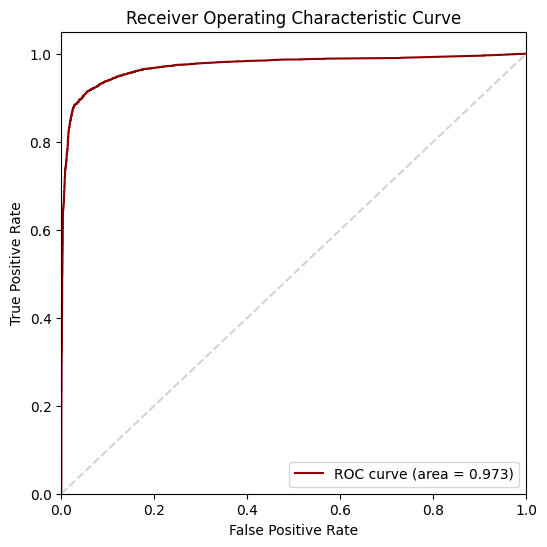

0.9726277446392697

In [ ]:
# --- Construct the training and testing sets ---
residual_g, train_samples, train_labels, test_samples, test_labels = generate_samples(graph=G0, train_set_ratio=0.6)

# --- Create feature vector for all edges in training set and test set ---
train_features = feature_extractor(residual_g, train_samples)
test_features = feature_extractor(residual_g, test_samples)

# --- Link prediction ---
prediction(residual_g, train_features, test_features, train_labels, test_labels)

Here, the AUC (Area Under the Curve) is 0.973, which demonstrates the effectiveness of this model in predicting a potential link between two airports.

#### Prediction

Next, we want to predict wether there should be a link or not between two non-connected airports in the network.

In [ ]:
negatives = list(nx.non_edges(G0))

We create the features for the non-connected airports of the network.

In [ ]:
node_features = feature_extractor(G, negatives)

100%|██████████| 5437502/5437502 [05:11<00:00, 17434.48it/s]


We fit the model in the same way as before.

In [ ]:
#link prediction
clf = LogisticRegression(penalty ='l2', max_iter = 200)
clf.fit(train_features, train_labels)

LogisticRegression(max_iter=200)

We create a dataset showing the pairs of unconnected airports.

In [ ]:
res = pd.DataFrame(negatives).set_axis(['airport_1', 'airport_2'], axis=1)
res.head()

,airport_1,airport_2
0,AER,KPB
1,AER,TUI
2,AER,SHA
3,AER,OIM
4,AER,INN


Here, we want to display the probabilities from the logistic regression, in order to sort them in descending order (we want to know which airports are the most likely to be connected).

In [ ]:
test = pd.DataFrame(clf.predict_proba(node_features), columns=clf.classes_)
test = test.set_axis(['no_link', 'link'], axis=1)
test

,no_link,link
0,0.800874,0.199126
1,0.804750,0.195250
2,0.441444,0.558556
3,0.804750,0.195250
4,0.784796,0.215204
...,...,...
5437497,0.807690,0.192310
5437498,0.405230,0.594770
5437499,0.744728,0.255272
5437500,0.369628,0.630372


In [ ]:
df = pd.concat([res, test], axis=1)
df

,airport_1,airport_2,no_link,link
0,AER,KPB,0.800874,0.199126
1,AER,TUI,0.804750,0.195250
2,AER,SHA,0.441444,0.558556
3,AER,OIM,0.804750,0.195250
4,AER,INN,0.784796,0.215204
...,...,...,...,...
5437497,LSC,ABV,0.807690,0.192310
5437498,LSC,GIG,0.405230,0.594770
5437499,SEN,ABV,0.744728,0.255272
5437500,SEN,GIG,0.369628,0.630372


This is the final list of airports that have the highest chance of being connected (or that should be connected).

In [ ]:
df = df.sort_values(by = "link", ascending = False).reset_index().drop(columns = ["index", "no_link", "link"], axis = 1)
df.head(30)

,airport_1,airport_2
0,ARN,MRS
1,NRT,MCO
2,PHL,NCE
3,NRT,XIY
4,WAW,SAW
5,MCO,BCN
6,OPO,RAK
7,MCO,FCO
8,MAN,WRO
9,BLQ,NTE
